In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Preparación de los datos

In [2]:
extracted_data = pd.read_csv('data/openb_pod_list_cpu0.csv')
extracted_data.head()

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time
0,openb-pod-0000,12000,16384,1,1000,NaN,LS,Running,0,12537496,0.0
1,openb-pod-0001,6000,12288,1,460,NaN,LS,Running,427061,12902960,427061.0
2,openb-pod-0002,12000,24576,1,1000,NaN,LS,Running,1558381,12902960,1558381.0
3,openb-pod-0003,6000,12288,1,460,NaN,LS,Running,2690044,12902960,2690044.0
4,openb-pod-0004,12000,16384,1,1000,NaN,LS,Running,2758084,12902960,2758084.0


In [3]:
extracted_data.describe()

,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,creation_time,deletion_time,scheduled_time
count,7064.000000,7064.000000,7064.000000,7064.000000,0.0,7.064000e+03,7.064000e+03,6.203000e+03
mean,9376.856172,35446.847537,1.052237,809.428086,NaN,1.156213e+07,1.158930e+07,1.153303e+07
std,7669.191313,35133.357315,0.569124,258.497299,NaN,9.652399e+05,8.983035e+05,9.741989e+05
min,1000.000000,0.000000,1.000000,50.000000,NaN,0.000000e+00,9.964972e+06,0.000000e+00
25%,4000.000000,10600.000000,1.000000,650.000000,NaN,1.074247e+07,1.077293e+07,1.071519e+07
50%,11300.000000,31250.000000,1.000000,1000.000000,NaN,1.155749e+07,1.156850e+07,1.150651e+07
75%,11908.000000,49152.000000,1.000000,1000.000000,NaN,1.242952e+07,1.243846e+07,1.239838e+07
max,120200.000000,737280.000000,8.000000,1000.000000,NaN,1.290176e+07,1.290296e+07,1.290176e+07


In [4]:
data = extracted_data.copy()
data.fillna(0, inplace=True)  
data.describe()

,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,creation_time,deletion_time,scheduled_time
count,7064.000000,7064.000000,7064.000000,7064.000000,7064.0,7.064000e+03,7.064000e+03,7.064000e+03
mean,9376.856172,35446.847537,1.052237,809.428086,0.0,1.156213e+07,1.158930e+07,1.012732e+07
std,7669.191313,35133.357315,0.569124,258.497299,0.0,9.652399e+05,8.983035e+05,3.882199e+06
min,1000.000000,0.000000,1.000000,50.000000,0.0,0.000000e+00,9.964972e+06,0.000000e+00
25%,4000.000000,10600.000000,1.000000,650.000000,0.0,1.074247e+07,1.077293e+07,1.043457e+07
50%,11300.000000,31250.000000,1.000000,1000.000000,0.0,1.155749e+07,1.156850e+07,1.131273e+07
75%,11908.000000,49152.000000,1.000000,1000.000000,0.0,1.242952e+07,1.243846e+07,1.224874e+07
max,120200.000000,737280.000000,8.000000,1000.000000,0.0,1.290176e+07,1.290296e+07,1.290176e+07


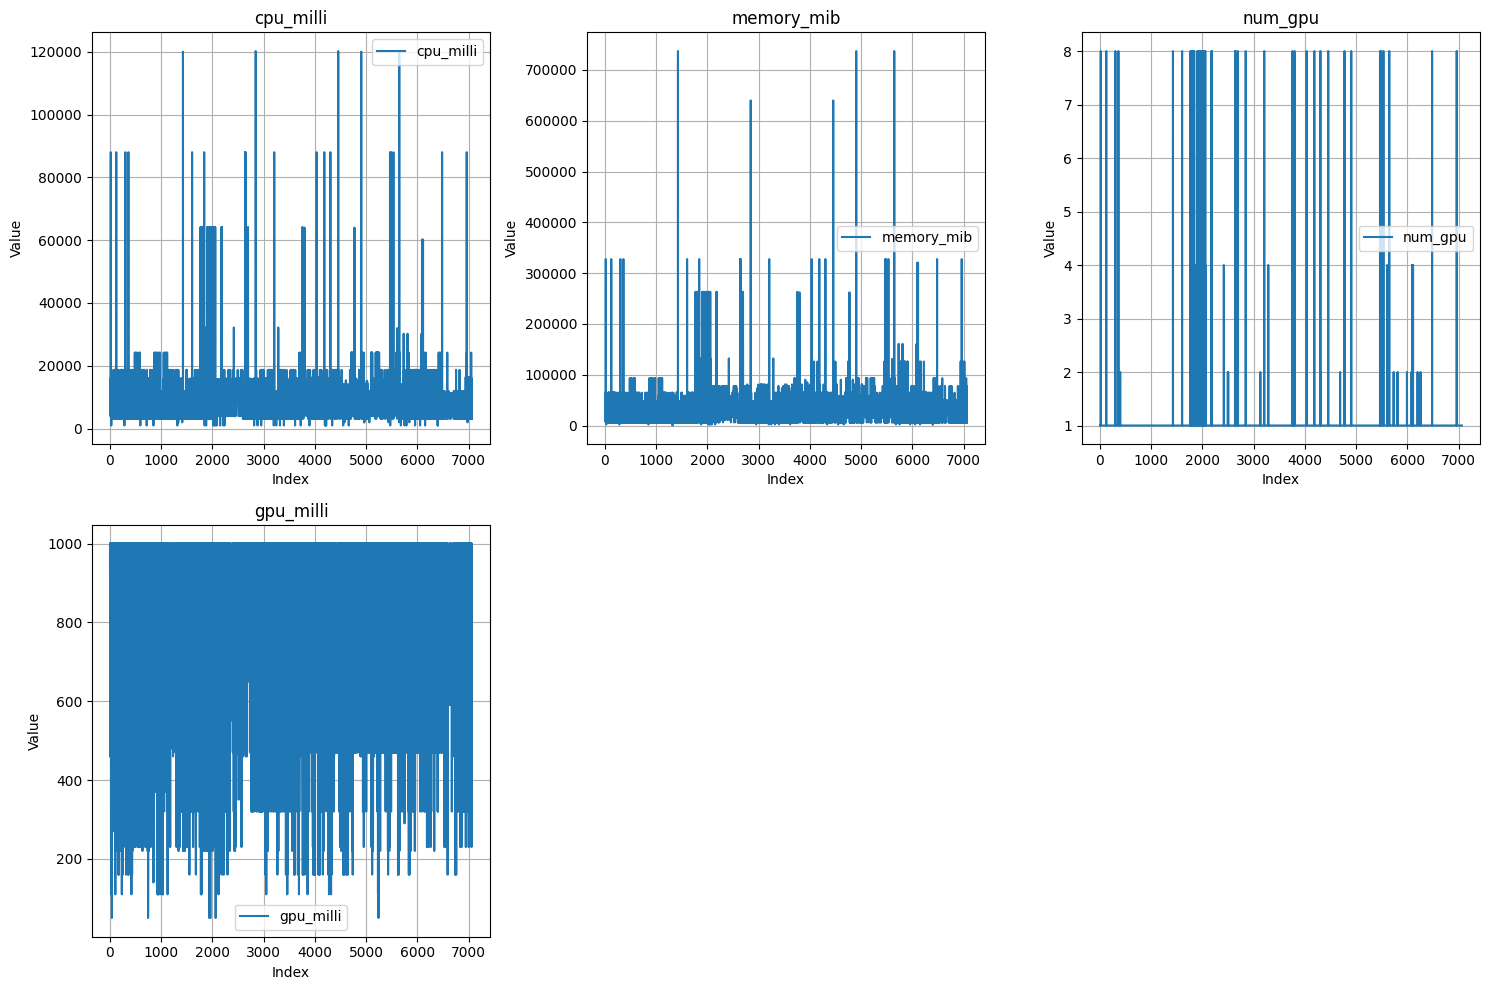

In [5]:
# Select only numeric columns
numeric_data = data[['cpu_milli', 'memory_mib','num_gpu', 'gpu_milli']]

import matplotlib.pyplot as plt

# Calcular el número de filas necesarias
n_columns = len(numeric_data.columns)
n_rows = (n_columns + 2) // 3  # Redondeo hacia arriba

# Crear una figura con subplots organizados en filas de 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Aplanar el arreglo de ejes para facilitar la iteración
axes = axes.flatten()

# Ocultar ejes sobrantes si el número de columnas no es múltiplo de 3
for ax in axes[n_columns:]:
    ax.axis('off')

# Graficar cada columna en su respectivo subplot
for ax, column in zip(axes, numeric_data.columns):
    ax.plot(numeric_data[column], label=column)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

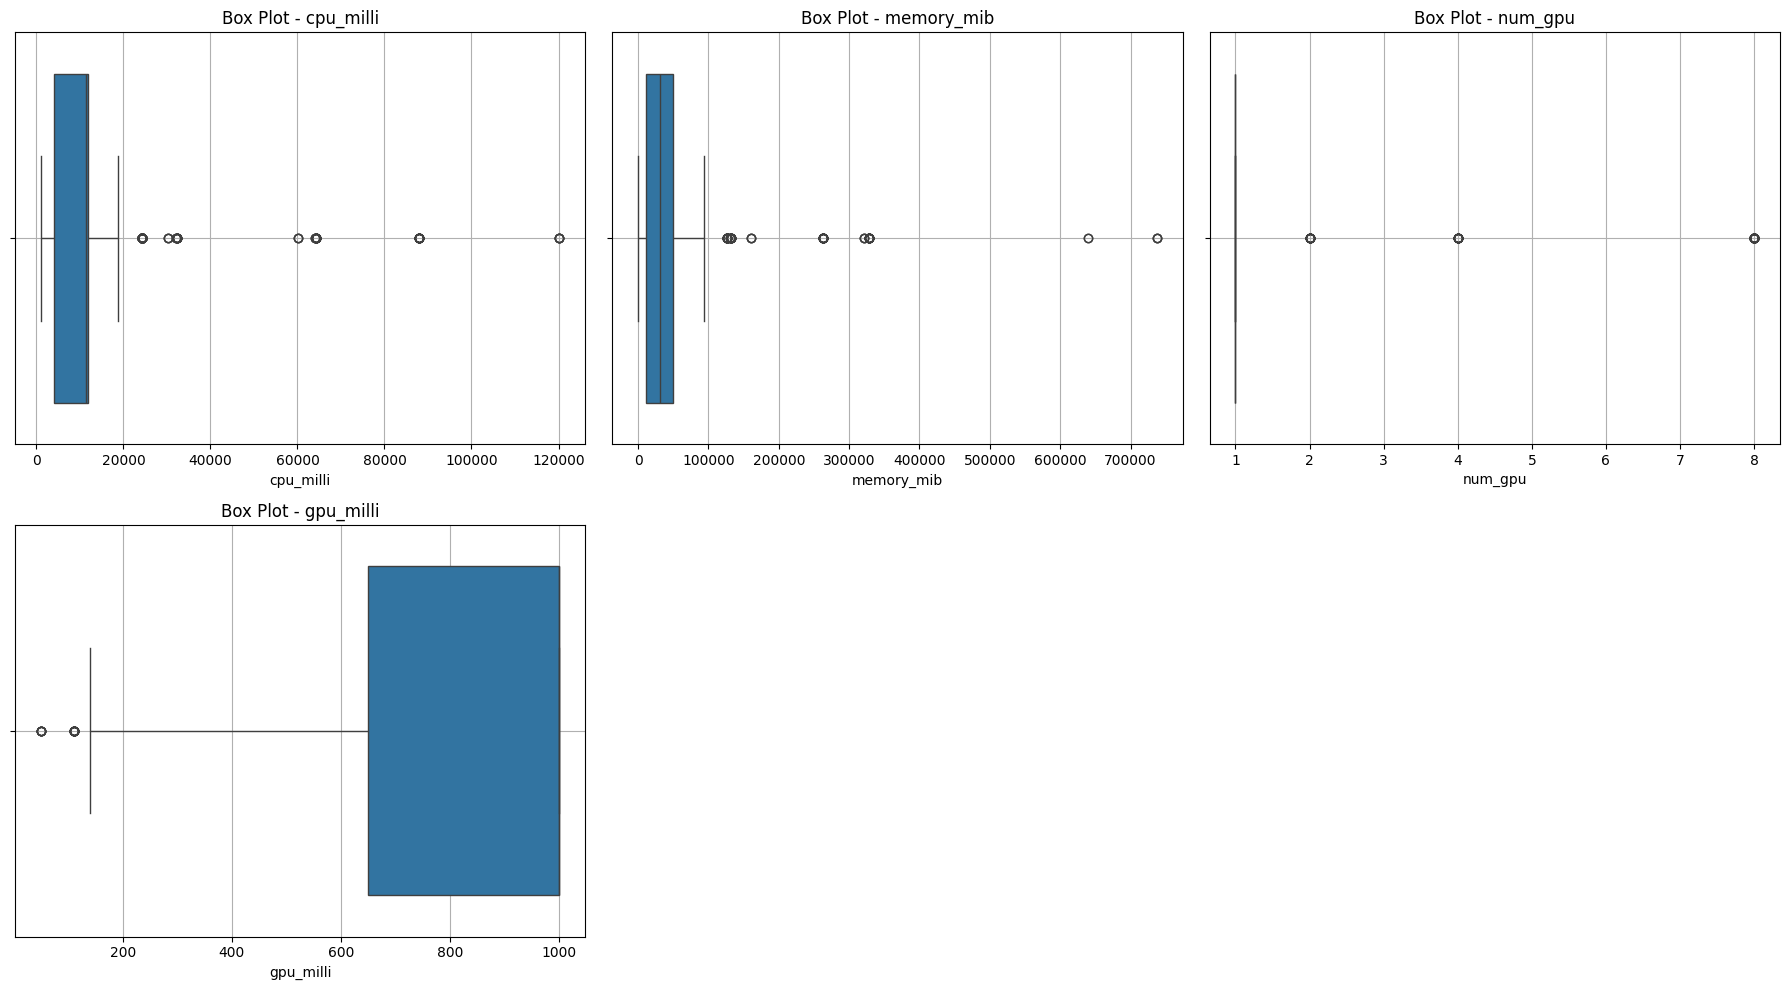

In [6]:
numeric_columns = numeric_data.select_dtypes(include=['float64', 'int64']).columns
n_plots = len(numeric_columns)

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
axes = axes.flatten()  

# Hide unused subplots if any
for ax in axes[n_plots:]:
    ax.axis('off')

# Plot each numeric column as a boxplot
for ax, column in zip(axes, numeric_data):
    sns.boxplot(data=numeric_data, x=column, ax=ax)
    ax.set_title(f"Box Plot - {column}")
    ax.set_xlabel(column)
    ax.grid(True)

plt.tight_layout()  # Prevent overlapping
plt.show()

# Regresión Lineal Multiple

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Excluir columnas irrelevantes (ej: gpu_spec si es constante)
numeric_data = data.copy()

numeric_data['duracion'] = numeric_data['deletion_time'] - numeric_data['creation_time']

numeric_data = numeric_data.drop(columns=['gpu_spec','creation_time', 'deletion_time', 'scheduled_time'], errors='ignore')


# Variables predictoras (excluir gpu_spec si es constante)
X = numeric_data[['cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli']]
y = numeric_data['duracion']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar datos (usamos RobustScaler por posibles outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predecir y evaluar
y_pred = model.predict(X_test_scaled)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

MSE: 80257383135.94
R²: 0.01


Error Cuadrático Medio (MSE): 80257383135.94
Coeficiente de Determinación (R²): 0.01


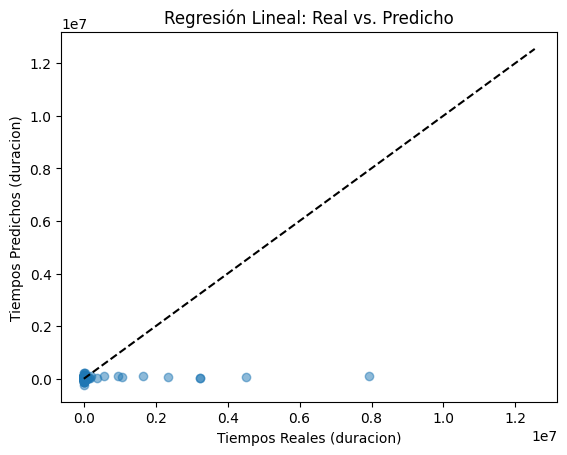

In [12]:
# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")

# Gráfico de valores reales vs. predichos
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Tiempos Reales (duracion)')
plt.ylabel('Tiempos Predichos (duracion)')
plt.title('Regresión Lineal: Real vs. Predicho')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')  # Línea de referencia
plt.show()

In [ ]:
# Obtener coeficientes del modelo
coeficientes = pd.DataFrame({
    'Variable': X.columns,
    'Impacto': model.coef_
})

print("\nImpacto de cada variable en scheduled_time:")
print(coeficientes)